<a href="https://colab.research.google.com/github/Raphael181/Color-flipper/blob/master/SMS_Text_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
# deep learning libraries for text pre-processing
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
# Modeling 
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GlobalAveragePooling1D, Dense, Dropout, LSTM, Bidirectional

In [2]:
# get data files
!wget https://cdn.freecodecamp.org/project-data/sms/train-data.tsv
!wget https://cdn.freecodecamp.org/project-data/sms/valid-data.tsv

train_file_path = "train-data.tsv"
test_file_path = "valid-data.tsv"

--2021-05-11 20:30:29--  https://cdn.freecodecamp.org/project-data/sms/train-data.tsv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 172.67.70.149, 104.26.2.33, 104.26.3.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|172.67.70.149|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 358233 (350K) [text/tab-separated-values]
Saving to: ‘train-data.tsv’

train-data.tsv      100%[===================>] 349.84K  --.-KB/s    in 0.04s   

2021-05-11 20:30:29 (8.08 MB/s) - ‘train-data.tsv’ saved [358233/358233]

--2021-05-11 20:30:29--  https://cdn.freecodecamp.org/project-data/sms/valid-data.tsv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 172.67.70.149, 104.26.2.33, 104.26.3.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|172.67.70.149|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 118774 (116K) [text/tab-separated-values]
Saving to: ‘valid-data.tsv’

valid-data.tsv      100%[==========

In [3]:
df_train = pd.read_csv(train_file_path, sep = '\t', names = ['label', 'message'])

In [4]:
#Data exploration
df_train

,label,message
0,ham,ahhhh...just woken up!had a bad dream about u ...
1,ham,you can never do nothing
2,ham,"now u sound like manky scouse boy steve,like! ..."
3,ham,mum say we wan to go then go... then she can s...
4,ham,never y lei... i v lazy... got wat? dat day ü ...
...,...,...
4174,ham,just woke up. yeesh its late. but i didn't fal...
4175,ham,what do u reckon as need 2 arrange transport i...
4176,spam,free entry into our £250 weekly competition ju...
4177,spam,-pls stop bootydelious (32/f) is inviting you ...


In [5]:
df_test = pd.read_csv(test_file_path, sep = '\t', names = ['label', 'messsage'])
df_test

,label,messsage
0,ham,i am in hospital da. . i will return home in e...
1,ham,"not much, just some textin'. how bout you?"
2,ham,i probably won't eat at all today. i think i'm...
3,ham,don‘t give a flying monkeys wot they think and...
4,ham,who are you seeing?
...,...,...
1387,ham,true dear..i sat to pray evening and felt so.s...
1388,ham,"what will we do in the shower, baby?"
1389,ham,where are you ? what are you doing ? are yuou ...
1390,spam,ur cash-balance is currently 500 pounds - to m...


In [6]:
df_train.describe()

,label,message
count,4179,4179
unique,2,3935
top,ham,"sorry, i'll call later"
freq,3619,22


In [7]:
duplicatedRow = df_train[df_train.duplicated()]
print(duplicatedRow[:5])

    label                                            message
298  spam  want to funk up ur fone with a weekly new tone...
385   ham  ok then i will come to ur home after half an hour
489   ham  watching cartoon, listening music &amp; at eve...
494   ham                             sorry, i'll call later
525   ham                             sorry, i'll call later


In [8]:
df_train.groupby('label').describe().T

label                              ham                                               spam
message count                     3619                                                560
        unique                    3430                                                505
        top     sorry, i'll call later  hmv bonus special 500 pounds of genuine hmv vo...
        freq                        22                                                  3

In [9]:
# Get all the ham and spam emails
ham_msg = df_train[df_train.label =='ham']
spam_msg = df_train[df_train.label=='spam']
# Create numpy list to visualize using wordcloud
ham_msg_text = " ".join(ham_msg.message.to_numpy().tolist())
spam_msg_text = " ".join(spam_msg.message.to_numpy().tolist())

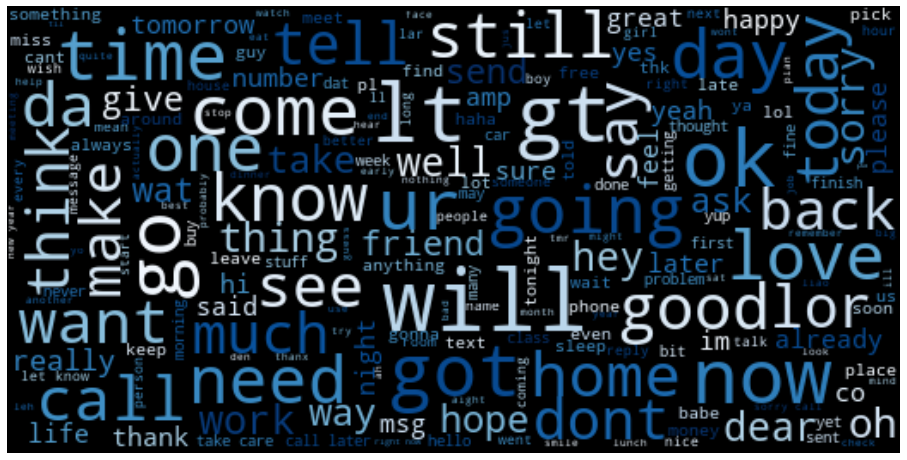

In [11]:
#Visualzing using Wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
%matplotlib inline
# wordcloud of ham messages
ham_msg_cloud = WordCloud(width =520, height =260, stopwords=STOPWORDS,max_font_size=50, background_color ="black", colormap='Blues').generate(ham_msg_text)
plt.figure(figsize=(16,10))
plt.imshow(ham_msg_cloud, interpolation='bilinear')
plt.axis('off') # turn off axis
plt.show()

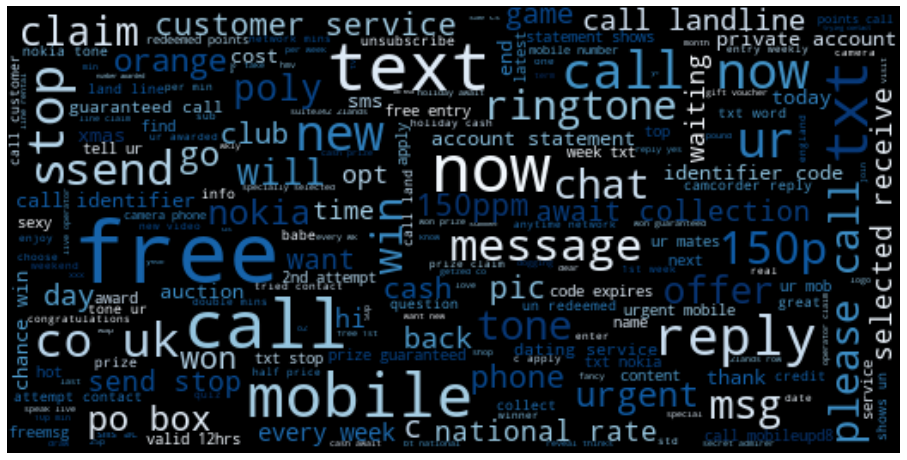

In [12]:
# wordcloud of spam messages
spam_msg_cloud = WordCloud(width =520, height =260, stopwords=STOPWORDS,max_font_size=50, background_color ="black", colormap='Blues').generate(spam_msg_text)
plt.figure(figsize=(16,10))
plt.imshow(spam_msg_cloud, interpolation='bilinear')
plt.axis('off') # turn off axis
plt.show()

(560, 2) (560, 2)


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'Message types')

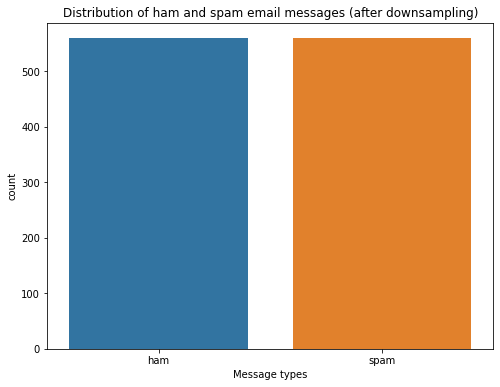

In [15]:
#Handling of imbalanced data:Downsample th ham msg
ham_msg_df = ham_msg.sample(n = len(spam_msg), random_state = 44)
spam_msg_df = spam_msg
print(ham_msg_df.shape, spam_msg_df.shape)

# Create a dataframe with these ham and spam msg
msg_df = ham_msg_df.append(spam_msg_df).reset_index(drop=True)
plt.figure(figsize=(8,6))
sns.countplot(msg_df.label)
plt.title('Distribution of ham and spam email messages (after downsampling)')
plt.xlabel('Message types')

In [16]:
# Get length column for each text
msg_df['text_length'] = msg_df['message'].apply(len)
#Calculate average length by label types
labels = msg_df.groupby('label').mean()
labels

,text_length
label,
ham,70.823214
spam,138.750000


In [17]:
#Prepairing our data
# Map ham label as 0 and spam as 1
msg_df['msg_type']= msg_df['label'].map({'ham': 0, 'spam': 1})
msg_label = msg_df['msg_type'].values
# Split data into train and test
train_msg, test_msg, train_labels, test_labels = train_test_split(msg_df['message'], msg_label, test_size=0.2, random_state=434)

In [18]:
#Text Preprocessing 
#Tokenization
# Defining pre-processing hyperparameters
max_len = 50 
trunc_type = "post" 
padding_type = "post" 
oov_tok = "<OOV>" 
vocab_size = 500

#use tokenizer to tokenize the words
tokenizer = Tokenizer(num_words=vocab_size, char_level=False, oov_token=oov_tok)
tokenizer.fit_on_texts(train_msg)

In [20]:
word_index = tokenizer.word_index
word_index
total_words = len(word_index)
print(f"There are {total_words} unique tokens in the training dataset")

There are 3471 unique tokens in the training dataset


In [21]:
#Sequencing and Padding on training and testing dataset
training_sequence = tokenizer.texts_to_sequences(train_msg)
training_paddded =pad_sequences(training_sequence, maxlen=max_len, padding = padding_type, truncating= trunc_type)

test_sequence = tokenizer.texts_to_sequences(test_msg)
test_paddded =pad_sequences(test_sequence, maxlen=max_len, padding = padding_type, truncating= trunc_type)


In [24]:
# Shape of train tensor
print('Shape of training tensor: ', training_paddded.shape)
print('Shape of testing tensor: ', test_paddded.shape)


Shape of training tensor:  (896, 50)
Shape of testing tensor:  (224, 50)


In [25]:
#Spam Detection Model
vocab_size = 500 # As defined earlier
embeding_dim = 16
dropout = 0.2 # dropout
n_dense = 24

In [27]:
#Dense model architecture
model = Sequential()
model.add(Embedding(vocab_size, embeding_dim, input_length=max_len))
model.add(GlobalAveragePooling1D())
model.add(Dense(24, activation='relu'))
model.add(Dropout(dropout))
model.add(Dense(1, activation='sigmoid'))

In [28]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 16)            8000      
_________________________________________________________________
global_average_pooling1d_1 ( (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 24)                408       
_________________________________________________________________
dropout (Dropout)            (None, 24)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 25        
Total params: 8,433
Trainable params: 8,433
Non-trainable params: 0
_________________________________________________________________


In [29]:
#compile
model.compile(optimizer='adam', loss='binary_crossentropy', metrics  =['accuracy'])

#train the model
model.fit(training_paddded, train_labels, epochs = 30, validation_data=(test_paddded, test_labels), callbacks= [EarlyStopping(monitor='val_loss', patience=3)], verbose=2)

Epoch 1/30
28/28 - 1s - loss: 0.6881 - accuracy: 0.7310 - val_loss: 0.6808 - val_accuracy: 0.8393
Epoch 2/30
28/28 - 0s - loss: 0.6723 - accuracy: 0.8438 - val_loss: 0.6596 - val_accuracy: 0.8438
Epoch 3/30
28/28 - 0s - loss: 0.6429 - accuracy: 0.8694 - val_loss: 0.6208 - val_accuracy: 0.8705
Epoch 4/30
28/28 - 0s - loss: 0.5953 - accuracy: 0.8783 - val_loss: 0.5648 - val_accuracy: 0.8839
Epoch 5/30
28/28 - 0s - loss: 0.5316 - accuracy: 0.8862 - val_loss: 0.4956 - val_accuracy: 0.8839
Epoch 6/30
28/28 - 0s - loss: 0.4607 - accuracy: 0.8906 - val_loss: 0.4246 - val_accuracy: 0.8839
Epoch 7/30
28/28 - 0s - loss: 0.3867 - accuracy: 0.9074 - val_loss: 0.3618 - val_accuracy: 0.8884
Epoch 8/30
28/28 - 0s - loss: 0.3257 - accuracy: 0.9107 - val_loss: 0.3124 - val_accuracy: 0.8973
Epoch 9/30
28/28 - 0s - loss: 0.2776 - accuracy: 0.9208 - val_loss: 0.2735 - val_accuracy: 0.9018
Epoch 10/30
28/28 - 0s - loss: 0.2438 - accuracy: 0.9252 - val_loss: 0.2433 - val_accuracy: 0.9062
Epoch 11/30
28/28 -

In [30]:
model.evaluate(test_paddded, test_labels)

7/7 [==============================] - 0s 2ms/step - loss: 0.0816 - accuracy: 0.9643


[0.08156248182058334, 0.9642857313156128]

In [39]:
def predict_message(pred_text):
  new_seq = tokenizer.texts_to_sequences(pred_text)
  padded = pad_sequences(new_seq, maxlen=max_len, padding=padding_type, truncating= trunc_type)
  return (model.predict(padded))

pred_text = ["how are you doing today?"]

predict_message(pred_text)


array([[0.01248491]], dtype=float32)

In [37]:
# Run this cell to test your function and model. Do not modify contents.
def test_predictions():
  test_messages = ["how are you doing today",
                   "sale today! to stop texts call 98912460324",
                   "i dont want to go. can we try it a different day? available sat",
                   "our new mobile video service is live. just install on your phone to start watching.",
                   "you have won £1000 cash! call to claim your prize.",
                   "i'll bring it tomorrow. don't forget the milk.",
                   "wow, is your arm alright. that happened to me one time too"
                  ]

  test_answers = ["ham", "spam", "ham", "spam", "spam", "ham", "ham"]
  passed = True

  for msg, ans in zip(test_messages, test_answers):
    prediction = predict_message(msg)
    if prediction[1] != ans:
      passed = False

  if passed:
    print("You passed the challenge. Great job!")
  else:
    print("You haven't passed yet. Keep trying.")

test_predictions()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


You haven't passed yet. Keep trying.
